In [117]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

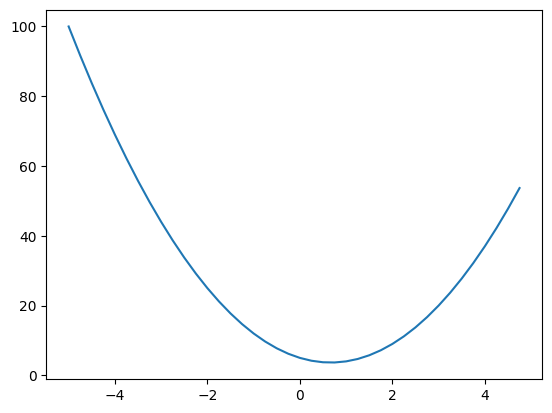

In [4]:
xs = np.arange(-5,5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [103]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
  
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad = (1 - (t**2)) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
          self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward
        
        return out
    
    def backward(self):
        visited = set()
        topo = []
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [96]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value (10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

print(L)

Value(data=-8.0, label=L)


In [97]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

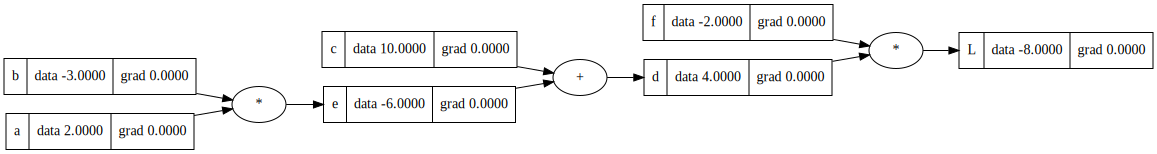

In [82]:
draw_dot(L)

 tanh backward of n
 add backward of x1*w1 + x2*w2 and other b
 add backward of x1*w1 and other x2*w2
 mult backward of x1 and other w1
 mult backward of x2 and other w2


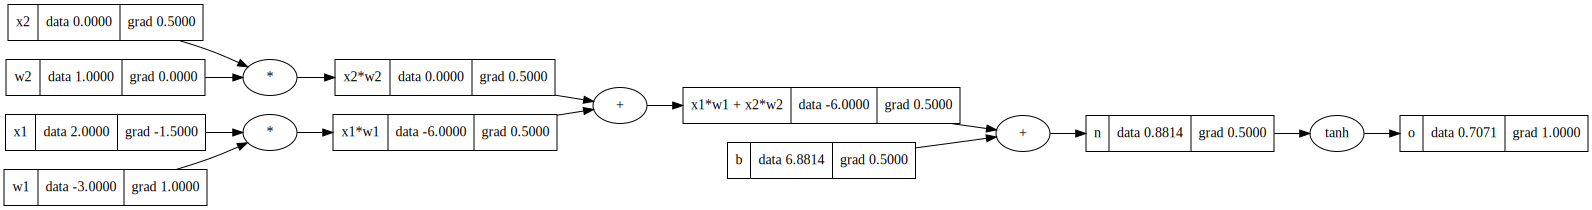

In [102]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)


## ----
#e = (2*n).exp()
#o = (e - 1) / (e + 1)
## ----
#o.label = 'o'
#o.backward()
#draw_dot(o)

In [143]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

       

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self. layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [144]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7989696369928534, label=)

In [145]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [152]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 0.006711507561094895
1 0.006584166330469864
2 0.006461349667848137
3 0.006342825931136407
4 0.006228378813864607
5 0.006117806108272865
6 0.0060109185854278786
7 0.0059075389797153995
8 0.005807501066589398
9 0.005710648823786504
10 0.005616835667367655
11 0.005525923754951198
12 0.005437783349376642
13 0.00535229223680114
14 0.005269335193899337
15 0.0051888034994229245
16 0.005110594485890998
17 0.005034611127634669
18 0.0049607616618192645
19 0.00488895923941951


In [153]:
ypred

[Value(data=0.9527328915505703, label=),
 Value(data=-0.9842923140046669, label=),
 Value(data=-0.9595963494668156, label=),
 Value(data=0.9721505238377149, label=)]

In [2]:
!pip3 install torch

  Using cached torch-2.2.2-cp39-none-macosx_10_9_x86_64.whl (150.8 MB)
     |████████████████████████████████| 1.6 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 177 kB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 6.2 MB 6.6 MB/s eta 0:00:01     |█████████████████               | 3.3 MB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 536 kB 7.5 MB/s eta 0:00:01
You should consider upgrading via the '/Users/hap-106/dev/nn_course/vnn_course_env/bin/python3 -m pip install --upgrade pip' command.
